In [1]:
!git clone https://github.com/neef02/Alzheimer-Detection-2

Cloning into 'Alzheimer-Detection-2'...
remote: Enumerating objects: 6407, done.
remote: Counting objects: 100% (6407/6407), done.
remote: Compressing objects: 100% (6406/6406), done.
remote: Total 6407 (delta 0), reused 6407 (delta 0), pack-reused 0
Receiving objects: 100% (6407/6407), 32.95 MiB | 29.70 MiB/s, done.


In [11]:
import os
import shutil
import random


data_dire = '/content/Alzheimer-Detection-2'
train_dire = '/content/train_data'
valid_dire = '/content/valid_data'
test_dire = '/content/test_data'

os.makedirs(train_dire, exist_ok=True)
os.makedirs(valid_dire, exist_ok=True)
os.makedirs(test_dire, exist_ok=True)


classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


train_split = 0.70
valid_split = 0.10
test_split = 0.20

for className in classes:
    class_dire = os.path.join(data_dire, className)
    images = os.listdir(class_dire)
    random.shuffle(images)  # Shuffle images in each class

    num_images = len(images)
    train_end = int(train_split * num_images)
    valid_end = int((train_split + valid_split) * num_images)


    train_images = images[:train_end]
    valid_images = images[train_end:valid_end]
    test_images = images[valid_end:]


    for img in train_images:
        src = os.path.join(class_dire, img)
        dst = os.path.join(train_dire, className, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in valid_images:
        src = os.path.join(class_dire, img)
        dst = os.path.join(valid_dire, className, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dire, img)
        dst = os.path.join(test_dire, className, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)



In [12]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers



In [13]:


train_dire = '/content/train_data'

filepath = [os.path.join(train_dire, fold, file)
             for fold in os.listdir(train_dire)
             for file in os.listdir(os.path.join(train_dire, fold))]

label = [fold for fold in os.listdir(train_dire)
          for _ in os.listdir(os.path.join(train_dire, fold))]

train_data = pd.DataFrame({'filepaths': filepath, 'labels': label})

In [5]:
train_data

filepaths            labels
0     /content/train_data/ModerateDemented/moderateD...  ModerateDemented
1           /content/train_data/ModerateDemented/28.jpg  ModerateDemented
2     /content/train_data/ModerateDemented/moderateD...  ModerateDemented
3           /content/train_data/ModerateDemented/32.jpg  ModerateDemented
4     /content/train_data/ModerateDemented/moderateD...  ModerateDemented
...                                                 ...               ...
4474  /content/train_data/VeryMildDemented/verymildD...  VeryMildDemented
4475  /content/train_data/VeryMildDemented/verymildD...  VeryMildDemented
4476   /content/train_data/VeryMildDemented/29 (28).jpg  VeryMildDemented
4477  /content/train_data/VeryMildDemented/verymildD...  VeryMildDemented
4478  /content/train_data/VeryMildDemented/verymildD...  VeryMildDemented

[4479 rows x 2 columns]

In [14]:
import os
import pandas as pd


test_dire = '/content/test_data'

filepath = [os.path.join(test_dire, fold, file)
             for fold in os.listdir(test_dire)
             for file in os.listdir(os.path.join(test_dire, fold))]

label = [fold for fold in os.listdir(test_dire)
          for _ in os.listdir(os.path.join(test_dire, fold))]

test_data = pd.DataFrame({'filepaths': filepath, 'labels': label})

In [7]:
test_data

filepaths            labels
0     /content/test_data/ModerateDemented/moderateDe...  ModerateDemented
1     /content/test_data/ModerateDemented/moderateDe...  ModerateDemented
2     /content/test_data/ModerateDemented/moderateDe...  ModerateDemented
3     /content/test_data/ModerateDemented/moderateDe...  ModerateDemented
4        /content/test_data/ModerateDemented/28 (2).jpg  ModerateDemented
...                                                 ...               ...
1277  /content/test_data/VeryMildDemented/verymildDe...  VeryMildDemented
1278  /content/test_data/VeryMildDemented/verymildDe...  VeryMildDemented
1279  /content/test_data/VeryMildDemented/verymildDe...  VeryMildDemented
1280  /content/test_data/VeryMildDemented/verymildDe...  VeryMildDemented
1281  /content/test_data/VeryMildDemented/verymildDe...  VeryMildDemented

[1282 rows x 2 columns]

In [15]:


val_dire = '/content/valid_data'

filepath = [os.path.join(val_dire, fold, file)
             for fold in os.listdir(val_dire)
             for file in os.listdir(os.path.join(val_dire, fold))]

label = [fold for fold in os.listdir(val_dire)
          for _ in os.listdir(os.path.join(val_dire, fold))]

val_data = pd.DataFrame({'filepaths': filepath, 'labels': label})
val_data

filepaths            labels
0     /content/valid_data/ModerateDemented/moderateD...  ModerateDemented
1     /content/valid_data/ModerateDemented/moderateD...  ModerateDemented
2     /content/valid_data/ModerateDemented/moderateD...  ModerateDemented
3     /content/valid_data/ModerateDemented/moderateD...  ModerateDemented
4     /content/valid_data/ModerateDemented/moderateD...  ModerateDemented
...                                                 ...               ...
1200  /content/valid_data/VeryMildDemented/verymildD...  VeryMildDemented
1201  /content/valid_data/VeryMildDemented/verymildD...  VeryMildDemented
1202  /content/valid_data/VeryMildDemented/verymildD...  VeryMildDemented
1203  /content/valid_data/VeryMildDemented/verymildD...  VeryMildDemented
1204   /content/valid_data/VeryMildDemented/30 (20).jpg  VeryMildDemented

[1205 rows x 2 columns]

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (224, 224)
img_shape = (224, 224, 3) #channels = 3

train_gen = ImageDataGenerator ()

test_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_datagen = train_gen.flow_from_dataframe(
    train_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_datagen = test_gen.flow_from_dataframe(
    test_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

valid_datagen = test_gen.flow_from_dataframe(
    val_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 5809 validated image filenames belonging to 4 classes.
Found 2296 validated image filenames belonging to 4 classes.
Found 1205 validated image filenames belonging to 4 classes.


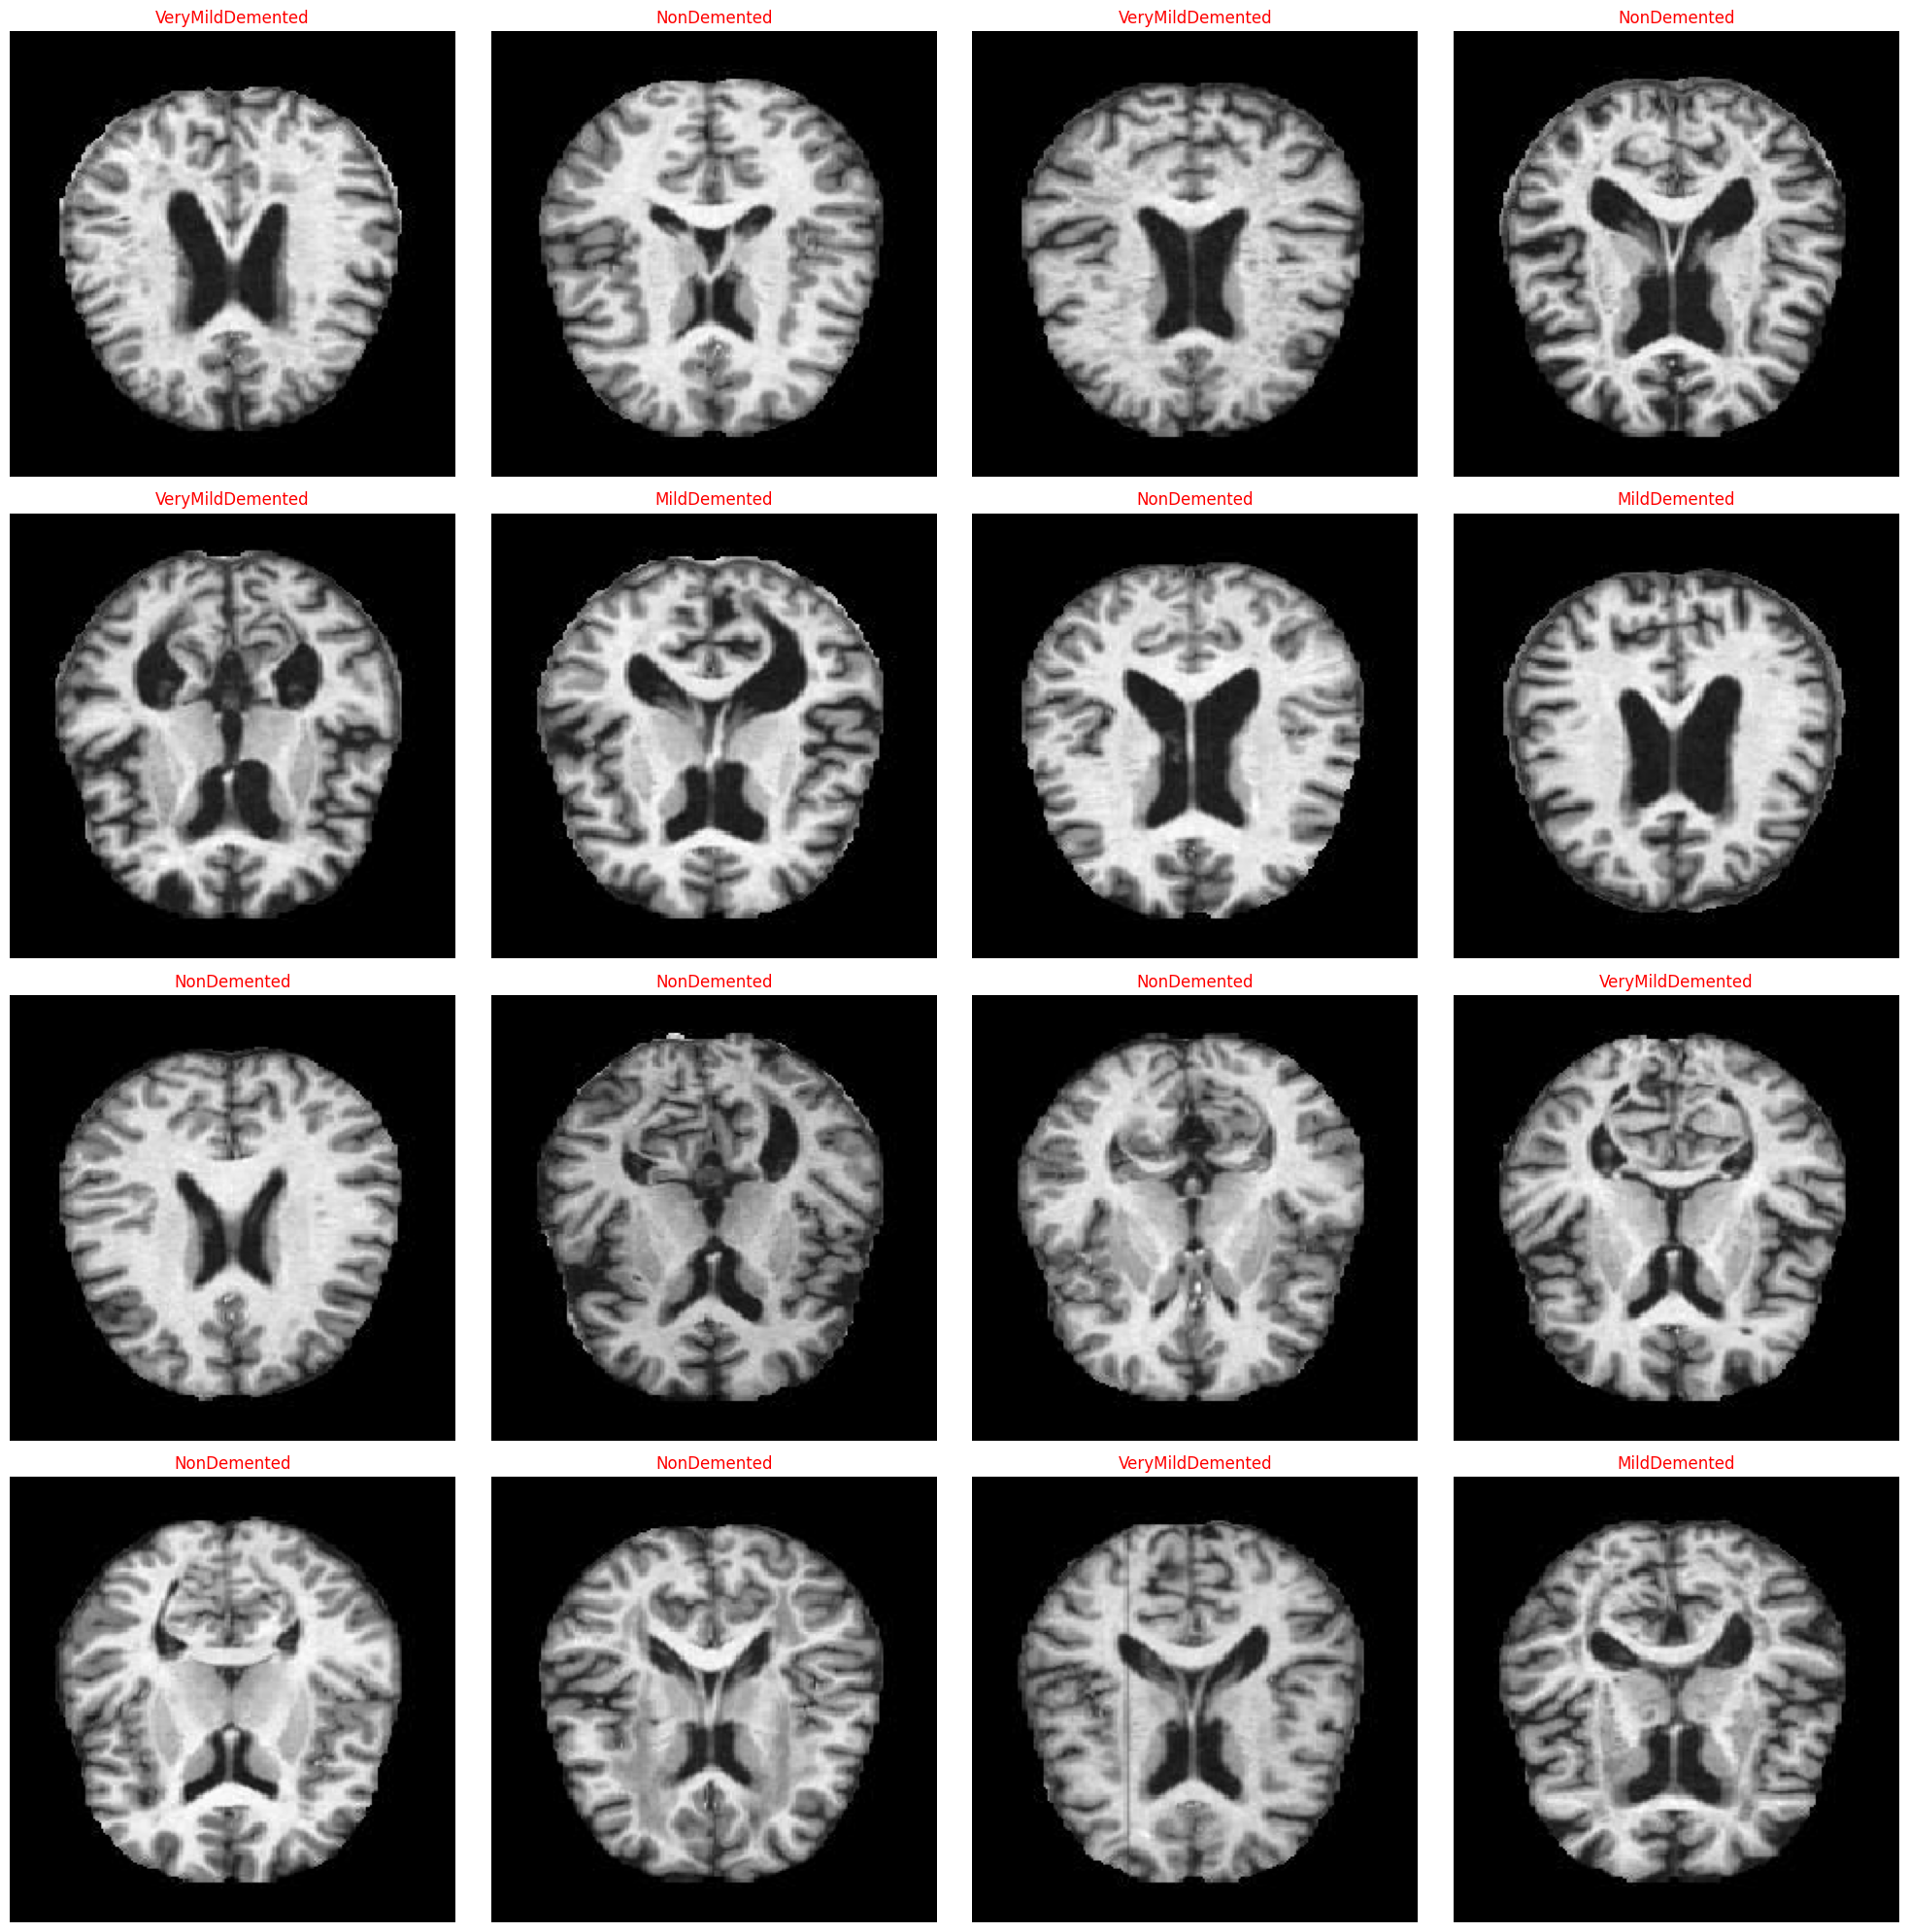

In [17]:

g_dict = train_datagen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_datagen)

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, (image, label) in enumerate(zip(images, labels)):
    if i < 16:
        ax = axs[i // 4, i % 4]
        image = image / 255
        ax.imshow(image)
        index = np.argmax(label)
        class_name = classes[index]
        ax.set_title(class_name, color='red', fontsize=12)
        ax.axis('off')


plt.tight_layout()
plt.show()

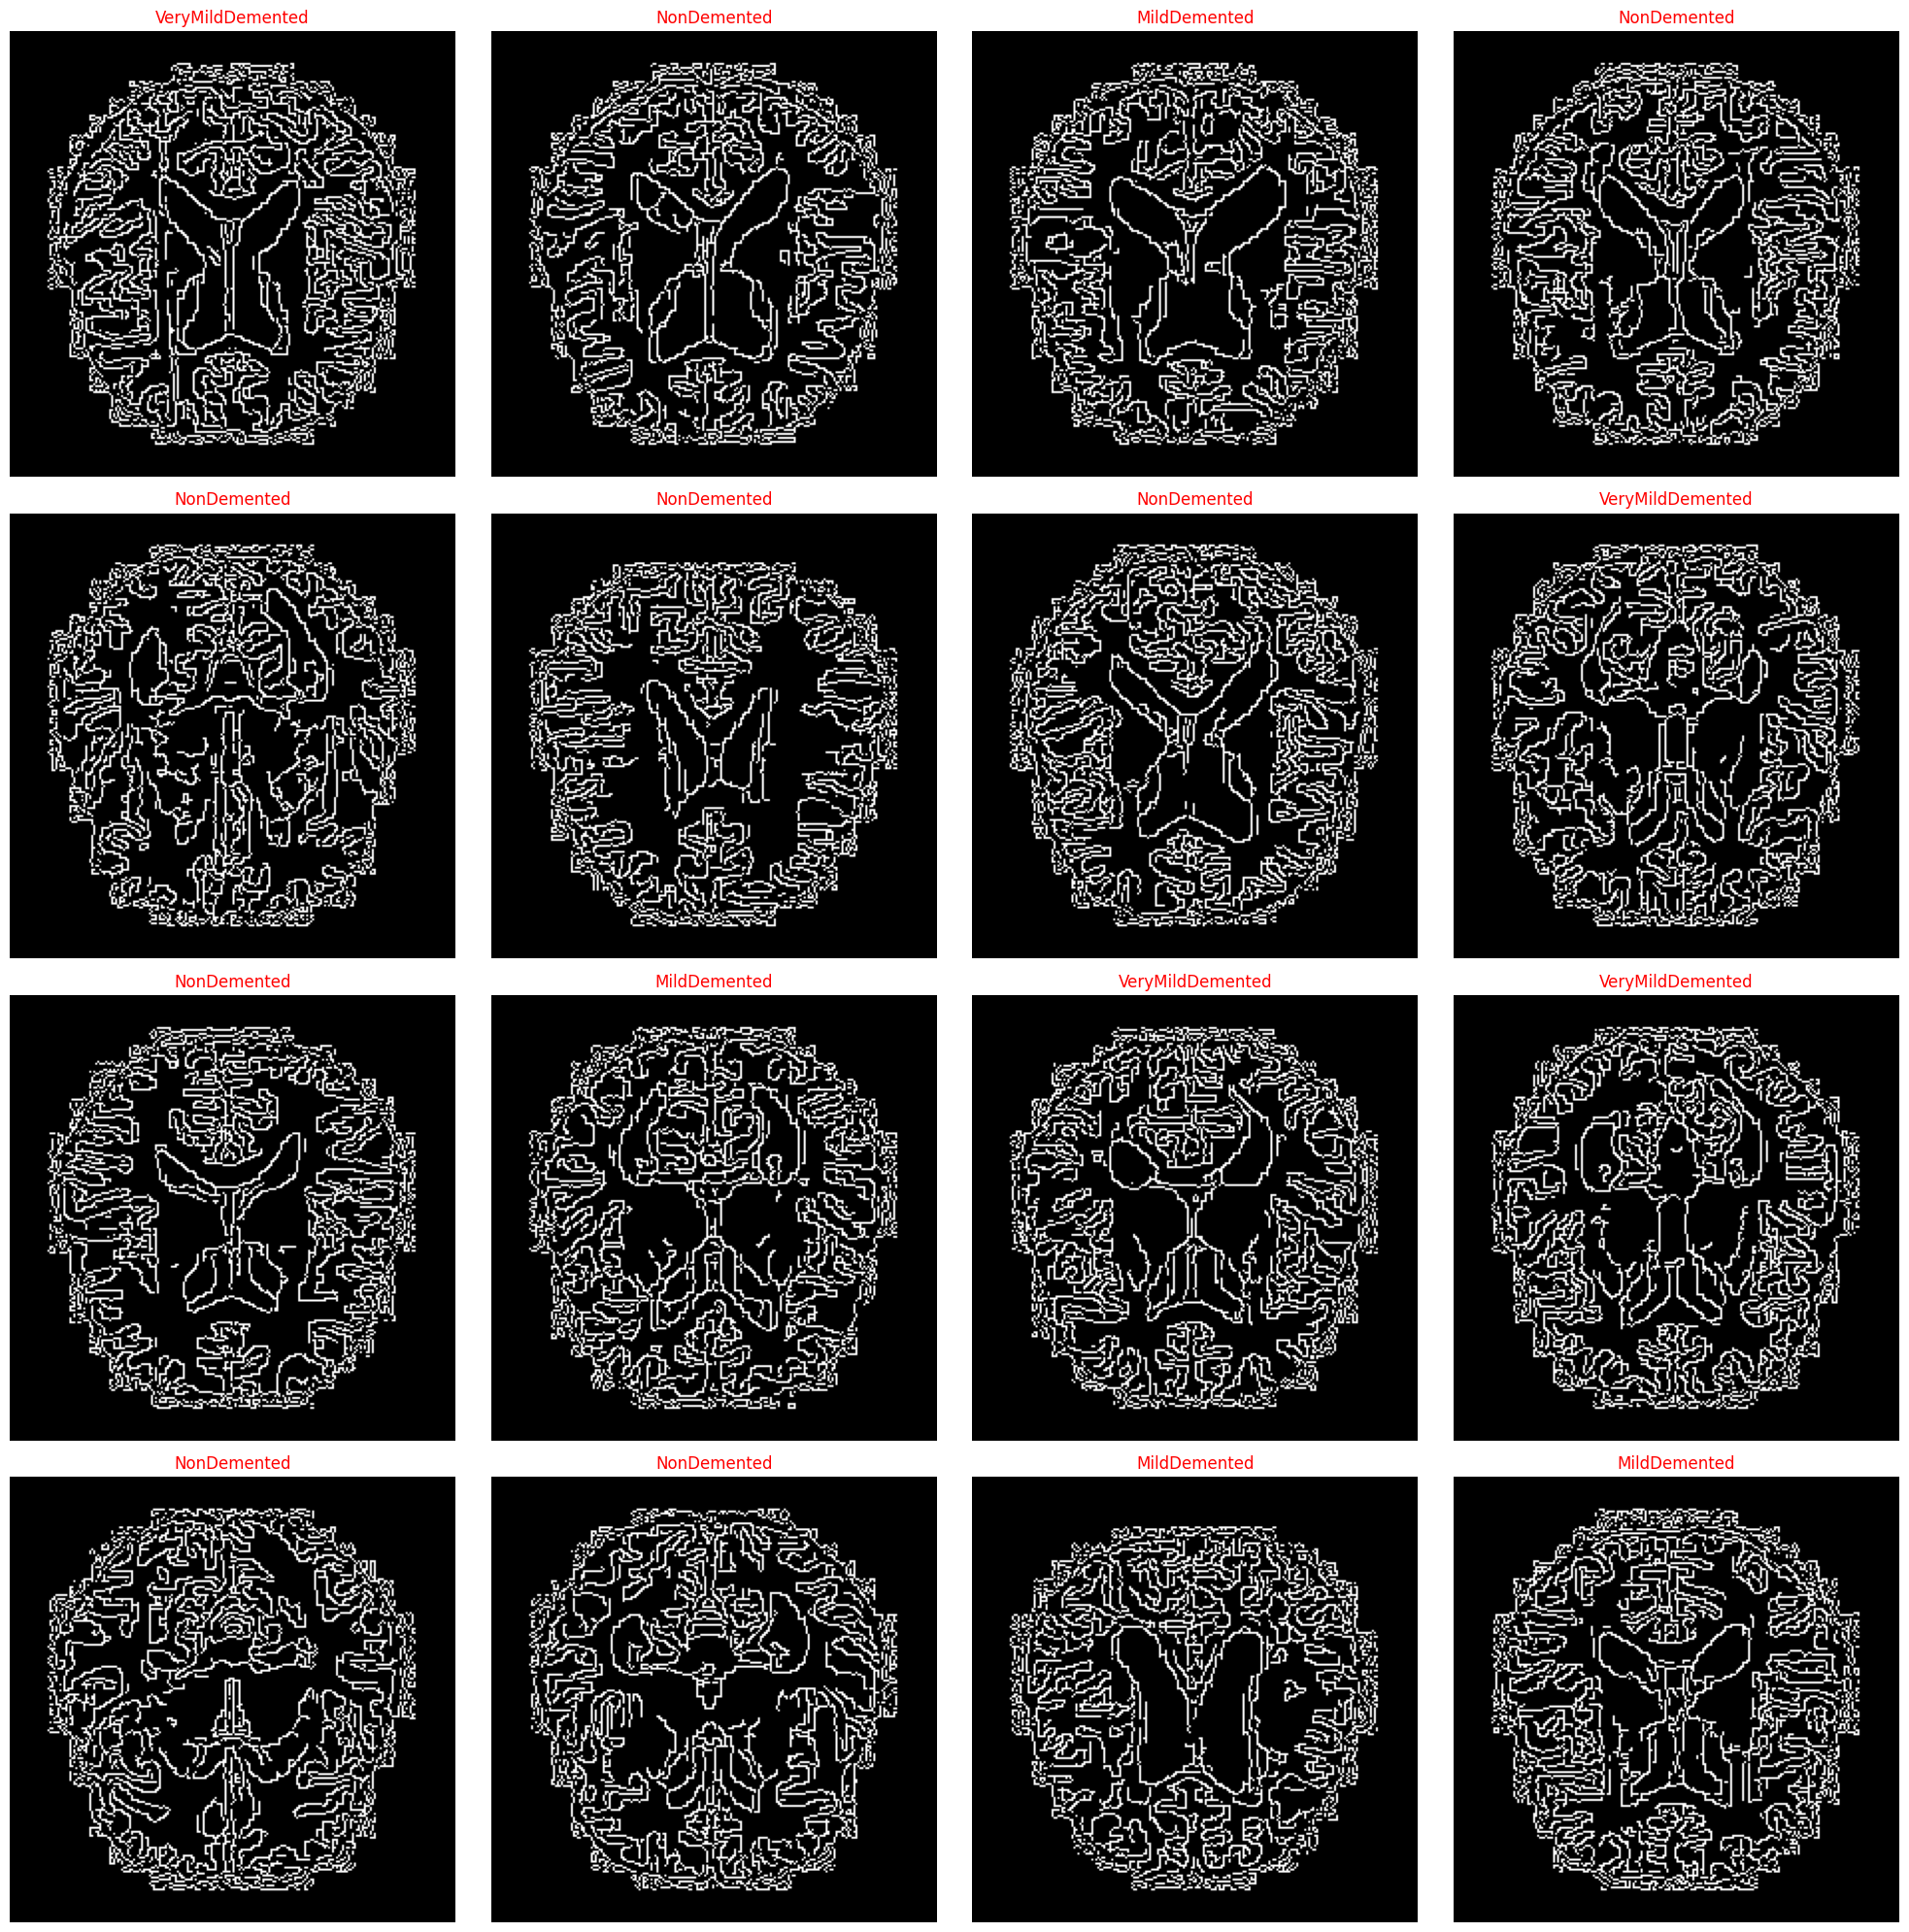

In [18]:
import cv2
import matplotlib.pyplot as plt


g_dict = train_datagen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_datagen)
fig, axs = plt.subplots(4, 4, figsize=(20, 20))


for i, (image, label) in enumerate(zip(images, labels)):
    if i < 16:
        ax = axs[i // 4, i % 4]
        image = (image * 255).astype('uint8')
        edges = cv2.Canny(image, 100, 200)
        ax.imshow(edges, cmap='gray')
        index = np.argmax(label)
        class_name = classes[index]
        ax.set_title(class_name, color='red', fontsize=12)
        ax.axis('off')


plt.tight_layout()
plt.show()

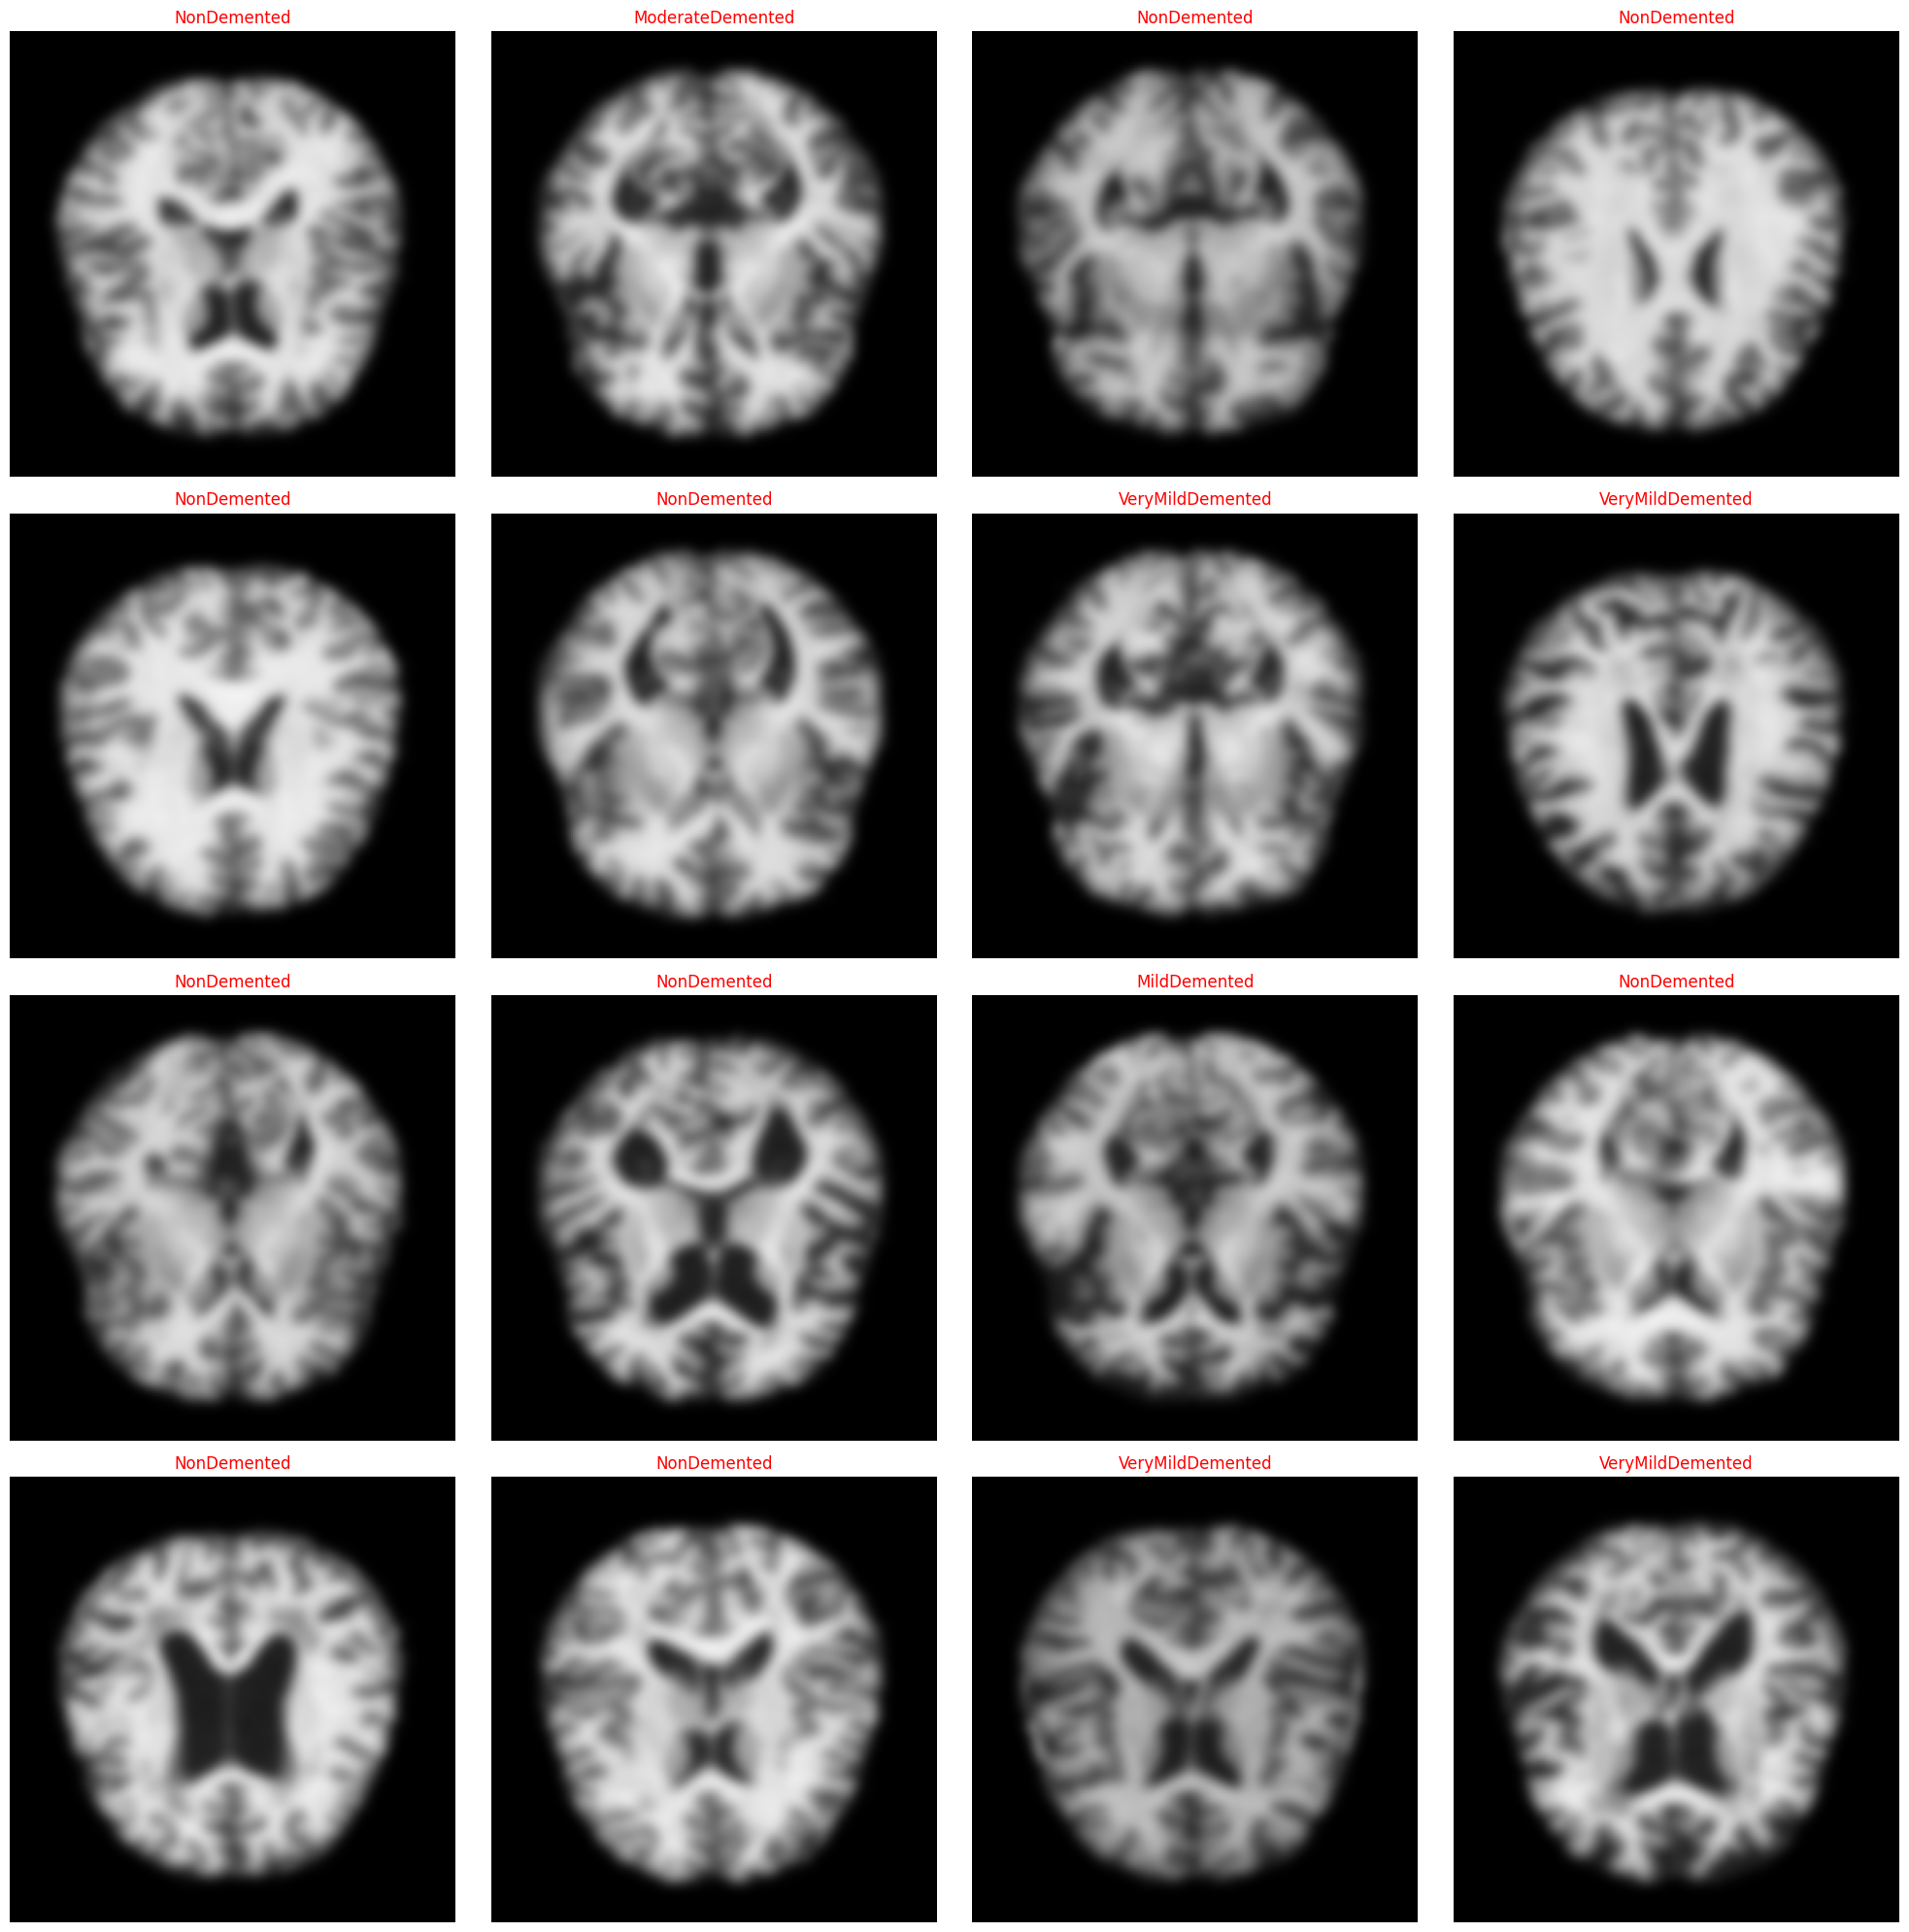

In [27]:

from scipy.ndimage import gaussian_filter


g_dict = train_datagen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_datagen)

# Limit the number of images to display to 16
num_images = min(16, images.shape[0])


fig, axs = plt.subplots(4, 4, figsize=(20, 20))


for i in range(num_images):
    ax = axs[i // 4, i % 4]


    image = images[i] / 255
    smoothed_image = gaussian_filter(image, sigma=3)
    ax.imshow(smoothed_image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    ax.set_title(class_name, color='red', fontsize=12)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

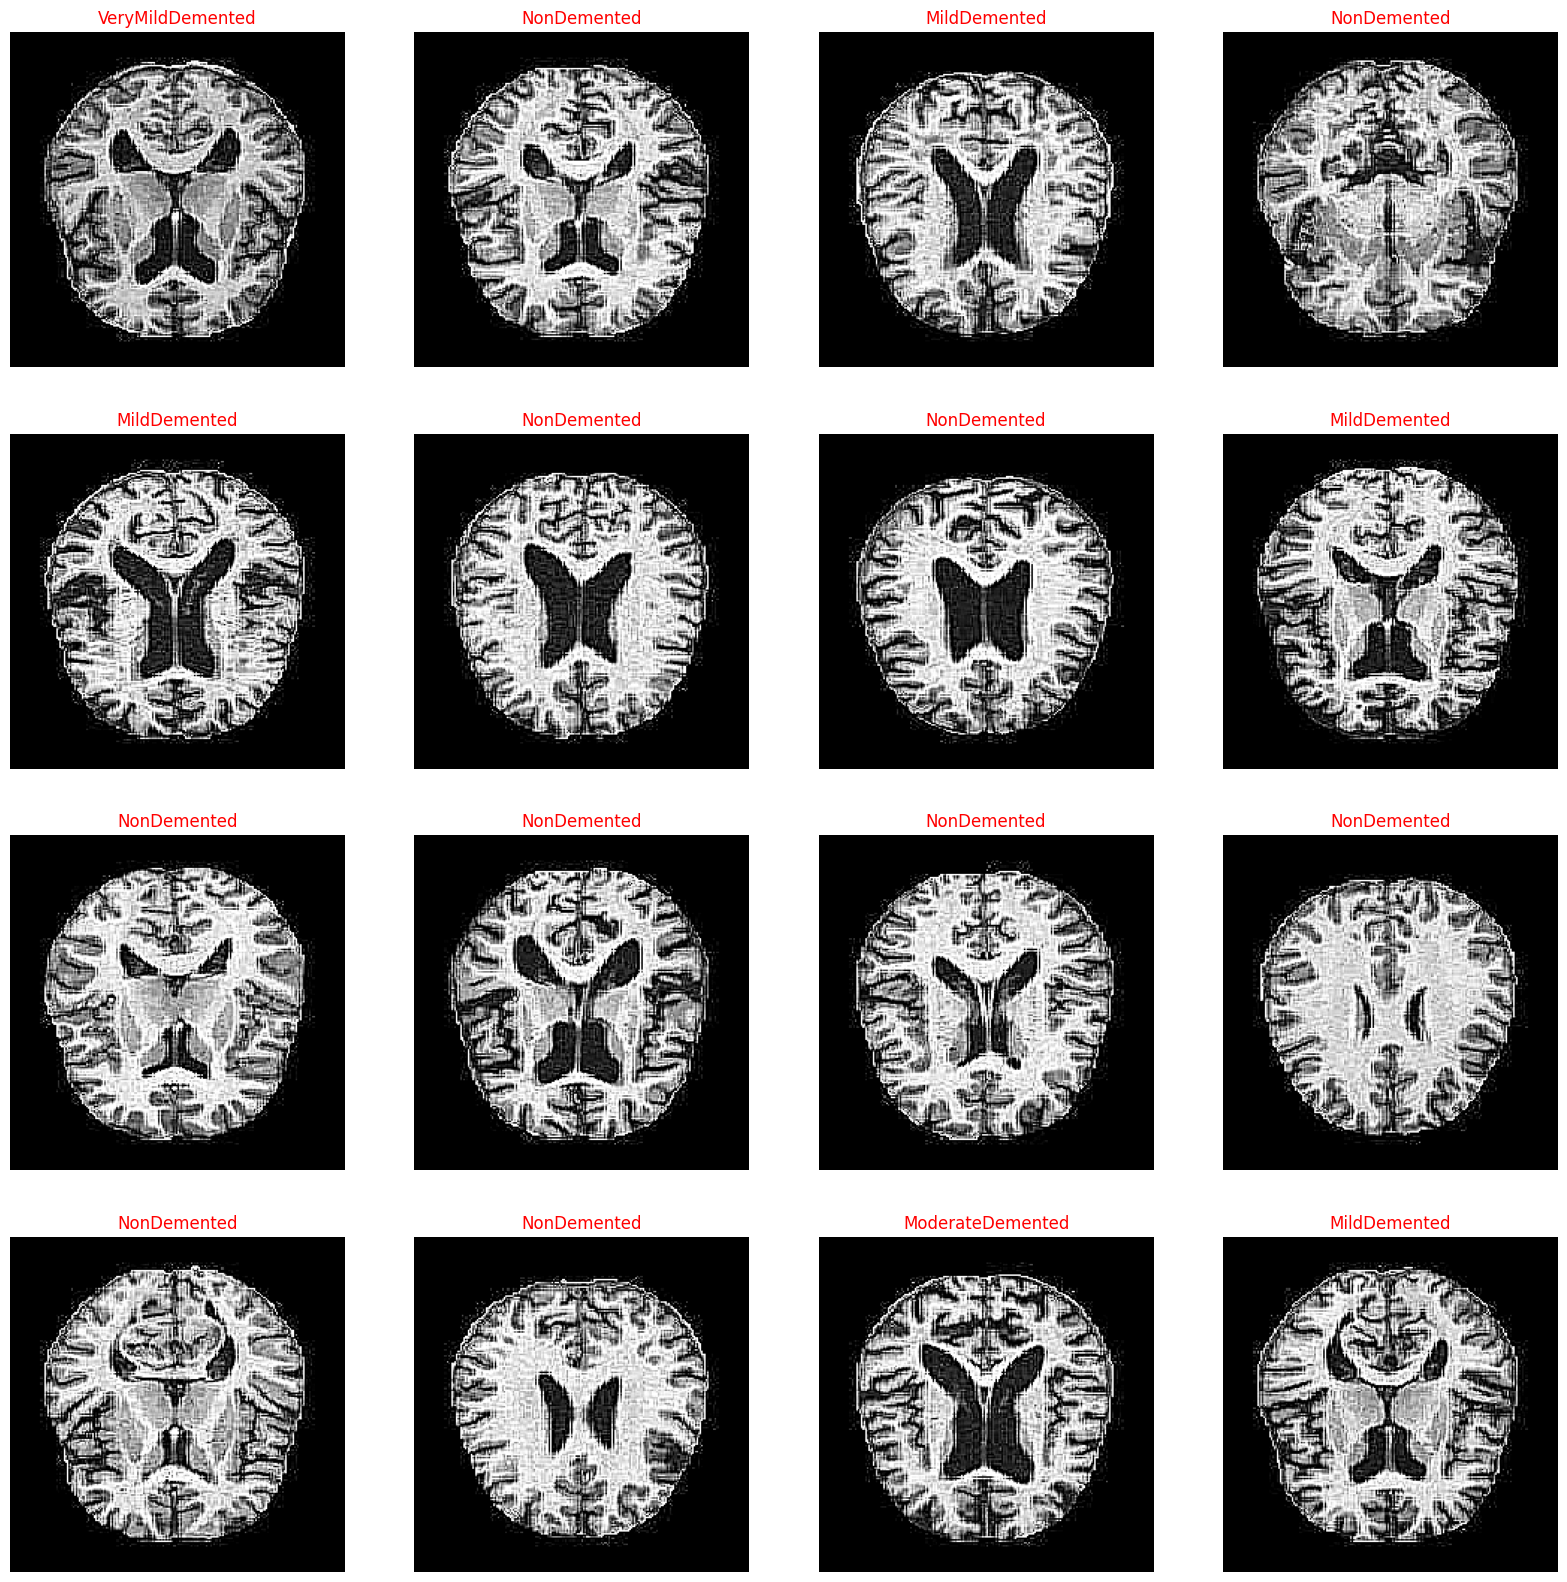

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

g_dict = train_datagen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_datagen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255

    # Apply sharpening filter
    sharpening_kernel = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)

    plt.imshow(sharpened_image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')

plt.show()

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB0

img_size = (224, 224)
img_shape = (224, 224, 3) # channels = 3
class_count = len(train_datagen.class_indices)

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
predictions = Dense(class_count, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
batch_size = 24   # set batch size for training
epochs = 10  # number of all epochs in training

history = model.fit(
    x=train_datagen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_datagen,
    validation_steps=None,
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10
195/195 [==============================] - 949s 5s/step - loss: 6.9040 - accuracy: 0.5772 - val_loss: 5.6259 - val_accuracy: 0.5733
Epoch 2/10
195/195 [==============================] - 951s 5s/step - loss: 4.3710 - accuracy: 0.7482 - val_loss: 4.1289 - val_accuracy: 0.5341
Epoch 3/10
195/195 [==============================] - 959s 5s/step - loss: 2.9082 - accuracy: 0.8856 - val_loss: 2.3973 - val_accuracy: 0.8880
Epoch 4/10
195/195 [==============================] - 945s 5s/step - loss: 1.9382 - accuracy: 0.9408 - val_loss: 1.4978 - val_accuracy: 0.9856
Epoch 5/10
195/195 [==============================] - 946s 5s/step - loss: 1.2723 - accuracy: 0.9722 - val_loss: 1.0058 - val_accuracy: 0.9867
Epoch 6/10
195/195 [==============================] - 944s 5s/step - loss: 0.8609 - accuracy: 0.9785 - val_loss: 0.7056 - val_accuracy: 0.9734
Epoch 7/10
195/195 [==============================] - 921s 5s/step - loss: 0.5784 - accuracy: 0.9848 - val_loss: 0.4419 - val_accuracy: 0.9942

In [ ]:
#Save the model
model.save('model.keras')

In [ ]:
import keras
saved_model = keras.models.load_model("model.keras")
saved_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
print(tr_acc)

[0.5771574974060059, 0.7481552958488464, 0.8856272101402283, 0.9408084750175476, 0.9722489714622498, 0.9785049557685852, 0.9847609996795654, 0.9852422475814819, 0.9842797517776489, 0.9881296157836914]


In [ ]:
ts_len = len(test_datagen)
test_bs = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))
test_stp = ts_len // test_bs

train = model.evaluate(train_datagen, steps= test_stp, verbose= 1)
valid = model.evaluate(valid_datagen, steps= test_stp, verbose= 1)
test = model.evaluate(test_datagen, steps= test_stp, verbose= 1)

print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

195/347 [===============>..............] - ETA: 2:43 - loss: 0.1780 - accuracy: 0.9997

 55/347 [===>..........................] - ETA: 5:04 - loss: 0.1789 - accuracy: 0.9994

 98/347 [=======>......................] - ETA: 4:24 - loss: 0.1791 - accuracy: 0.9994

347/347 [==============================] - 104s 298ms/step - loss: 0.1791 - accuracy: 0.9994
Train Loss:  0.1780007779598236
Train Accuracy:  0.9996792078018188


In [ ]:
from PIL import Image
path = '/content/test_data/ModerateDemented/moderateDem0.jpg'
image = Image.open(path)


img = keras.utils.load_img(path, target_size=(224, 224))
input_arr = keras.utils.img_to_array(img)
input_arr = np.array([input_arr])

# Make predictions
predictions = model.predict(input_arr)
predicted_index = np.argmax(predictions[0])
predicted_class = classes[predicted_index]



# Display the lines as a list

print(predicted_class,end="")

1/1 [==============================] - 2s 2s/step
ModerateDemented
